# LiMe Tutorial: Basic Operations
In this notebook we present a basic utilization of the `LiMe` Measuring library. This library was created to fit emission spectra for the chemical and kinematic analysis of ionized nebulae

To start you need to make sure you have the library installed. This can be done using pip:

```python
pip install lime-stable
```

LiMe has some dependencies which must be installed for its proper operation. In case you need to, please refer to their corresponding documenation for installation instructions:
* numpy (compulsory): Numerical operations
* LmFit (compulsory): Fitting algorithm
* pandas (compulsory): Handling input and output tables algorithm
* matplotlib (compulsory): Generating plots
* Astropy (optional): Opening and closing fits files
* PyNeb (optional): Handling emissivity and reddening operations
* PyLatex (optional): Generating pdf output files
* specutils (optional): Line finding

At this point you can import the library

## Loading spectra

Once you have installed the library, you may import it into your scripts

In [1]:
import lime

Please check the version you are version you are using, whenever you have a question/issue/comment you want to share at [github](https://github.com/Vital-Fernandez/lime).

In [35]:
print(lime.__version__)

0.1.8


We can start opening a spectrum. At this notebook location, you should also have available a sample data folder with a GTC spectrum of the galaxy GP121903.
You can open it using astropy:

In [36]:
import numpy as np
from astropy.io import fits

ext = 0
with fits.open('./sample_data/gp121903_BR.fits') as hdul:
    flux, header = hdul[ext].data, hdul[ext].header


The spectrum wavelength can be reconstructed from the header:

In [37]:
w_min = header['CRVAL1']
dw = header['CD1_1']
pixels = header['NAXIS1']
w_max = w_min + dw * pixels
wave = np.linspace(w_min, w_max, pixels, endpoint=False)

The main functions in `LiMe` are performed by the Spectrum class: This object stores your spectrum and performs the line fitting functions. Its most essential inputs are the spectrum wavelength and flux. However, in order to identify and labeling lines a redshift value is necessary. Finally, many line fitting functions will fail in CGS units commonly used in spectra. Consequently, it is recommended to introduce a normalization value. Despite these inputs, however, the measurements are performed in the observed framed and the results will be stored in the input flux units.

 In the case of GP121903 we have:

In [38]:
z_gp = 0.19531
normFlux_gp = 1e-14

Using this information, the Spectrum object is defined as:

In [39]:
gp_spec = lime.Spectrum(wave, flux, redshift=z_gp, normFlux=normFlux_gp)

As additional inputs, you may provide the sigma (uncertainty) spectrum and a two value array to crop the spectrum wavelength range (in the same frame as the input wavelength)

To display the spectrum you can use the function:

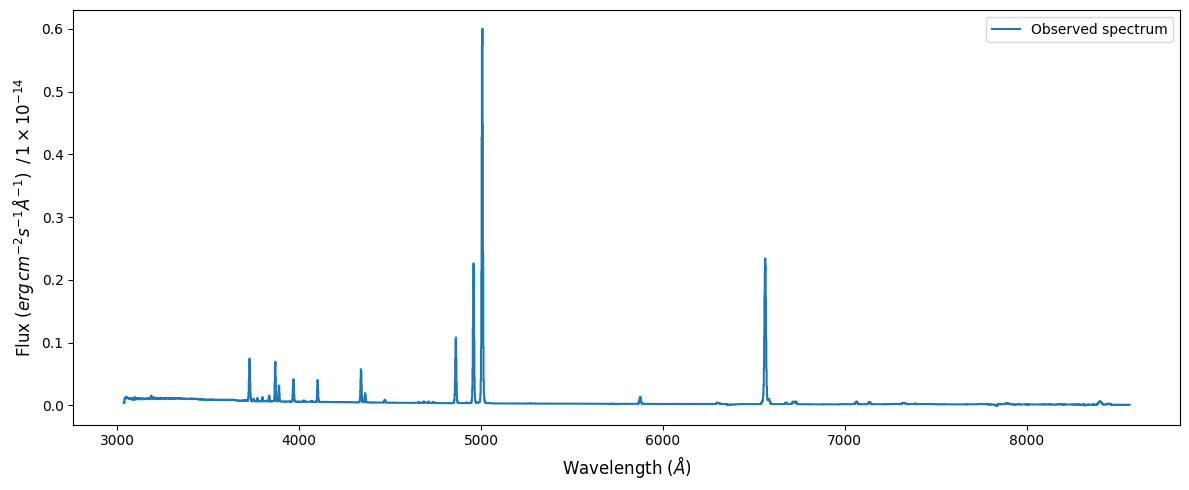

In [40]:
gp_spec.plot_spectrum()

To fit a line we need to provide its location: Two wavelengths marking the spectrum region where the line is located. Additionally, you need to define two continuum regions on the left and right hand side of the line. Therefore, you need to provide a six value array ordered from lower to higher wavelengths:
![Configuration file](images/line_regions.png)

For this Green Pea spectrum the Hα mask is:

In [41]:
lineWaves = np.array([6438.03, 6508.66, 6535.10, 6600.95, 6627.70, 6661.82])

In this array the first two values correspond to the left continuum, the third and fifth values correspond to the line region and the the final two values correspond to the right hand side continuum.
These values must be in the rest frame.

Let's fit the Hα line using the function fit_from_wavelengths

In [42]:
gp_spec.fit_from_wavelengths('H1_6563A', lineWaves)

You can plot the fit using:


Line label: H1_6563A
- Line regions: [6438.03 6508.66 6535.1  6600.95 6627.7  6661.82]
- Normalization flux: 1e-14
- Redshift: 0.19531
- Peak wavelength: 7845.85; peak intensity: 0.23
- Cont. slope: -6.02e-07; Cont. intercept: 6.72e-03

- H1_6563A Intg flux: 3.129 +/- 0.001
- H1_6563A Eqw (intg): 1573.54 +/- 8.15

- H1_6563A gaussian fitting:
-- Gauss flux: 2.905 +/- 0.019
-- Center: 7845.78 +/- 0.03
-- Sigma (km/s): 189.40 +/- 1.36



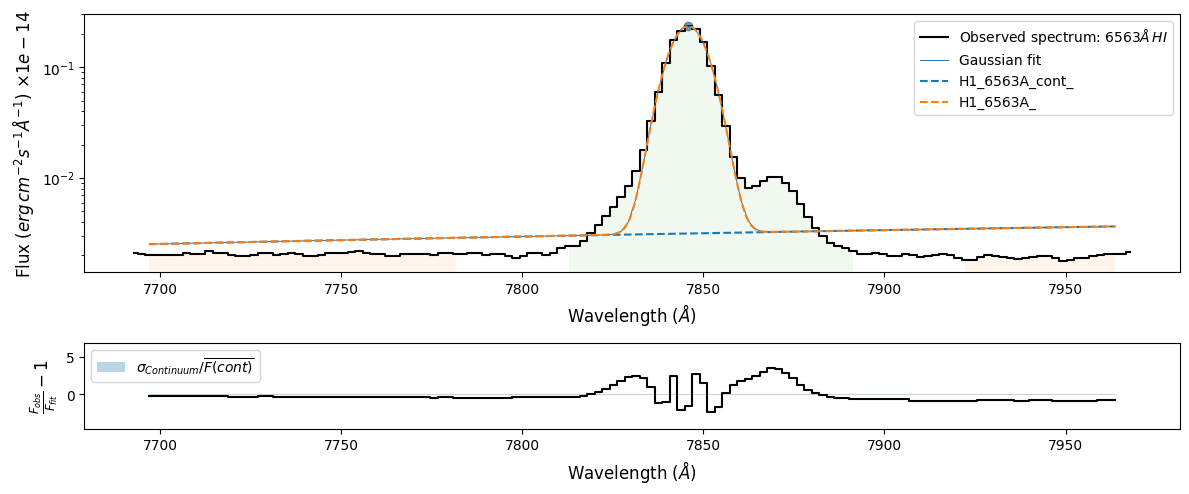

In [43]:
gp_spec.display_results(show_plot=True)

You can see that the fitting is not very good. Let's increase the complexity by including the [NII] lines:

In [44]:
Halpha_conf = {'H1_6563A_b': 'H1_6563A-N2_6584A-N2_6548A',
            'N2_6548A_amp': {'expr': 'N2_6584A_amp / 2.94'},
            'N2_6548A_kinem': 'N2_6584A'}

The dictionary above has three elements:
* First: The line labelled as 'H1_6563A_b' consists in three components: H1_6563A, N2_6584A and N2_6548A
* Second: The line labelled as 'N2_6548A' has an amplitude value fixed by the amplitude fitted in the line "N2_6584A"
* Three: The line labelled as 'N2_6548A' has its kinematics (both radial and dispersion velocity) imported from those fit in the line N2_6548A.

Using the conditions above we repeat the fitting:


Line label: H1_6563A_b
- Line regions: [6438.03 6508.66 6535.1  6600.95 6627.7  6661.82]
- Normalization flux: 1e-14
- Redshift: 0.19531
- Peak wavelength: 7845.85; peak intensity: 0.23
- Cont. slope: -6.02e-07; Cont. intercept: 6.72e-03

- H1_6563A_b Intg flux: 3.129 +/- 0.001

- H1_6563A gaussian fitting:
-- Gauss flux: 2.916 +/- 0.012
-- Center: 7845.78 +/- 0.02
-- Sigma (km/s): 189.09 +/- 0.84

- N2_6584A gaussian fitting:
-- Gauss flux: 0.144 +/- 0.014
-- Center: 7869.44 +/- 0.60
-- Sigma (km/s): 252.38 +/- 25.94

- N2_6548A gaussian fitting:
-- Gauss flux: 0.049 +/- 0.000
-- Center: 7826.41 +/- 0.60
-- Sigma (km/s): 252.38 +/- 25.94



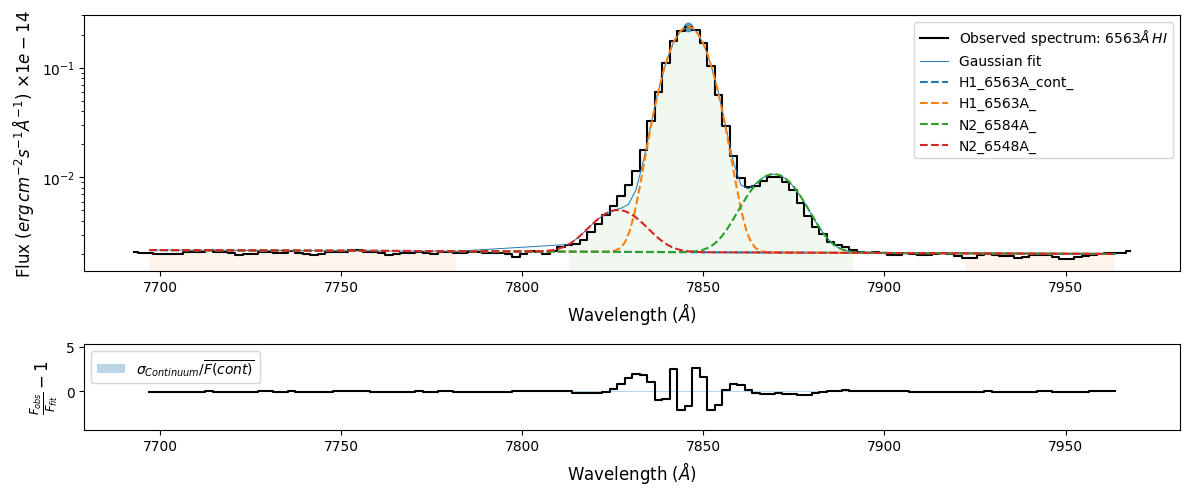

In [45]:
gp_spec.fit_from_wavelengths('H1_6563A_b', lineWaves, user_cfg=Halpha_conf)
gp_spec.display_results(show_plot=True)

This time the fit better represents the observed lines profile

## Fitting multiple lines

An important objective of this library is simplifying the fitting of many lines, while preserving the customization. This design splits the user inputs in several files. In the sample data folder alongside this notebook you may find a text file with the line masks. This table can be imported as a pandas dataframe using the function:

In [46]:
gp_mask = lime.load_lines_log('./sample_data/gp121903_BR_mask.txt')

Each line provides a line label along side six wavelength values (in the rest frame) describing the line regions and adjacent continua. This is the same format as in the Hα fitting above.

In [47]:
print(gp_mask)

                  w1       w2       w3       w4       w5       w6
H1_3704A     3685.00  3700.00  3700.45  3709.10  3758.00  3764.00
O2_3726A_m   3665.75  3694.26  3716.02  3743.70  3754.88  3767.50
H1_3750A     3663.49  3697.71  3743.70  3755.82  3775.22  3792.04
H1_3771A     3755.82  3763.43  3764.47  3776.58  3778.32  3791.62
H1_3798A     3776.99  3787.91  3788.69  3804.26  3843.10  3858.63
H1_3835A     3803.91  3814.15  3828.48  3844.05  3844.26  3852.83
Ne3_3869A    3800.00  3820.00  3857.89  3880.39  3905.00  3950.00
H1_3889A_m   3806.90  3828.20  3880.39  3899.42  3905.00  3950.00
H1_3970A     3932.80  3948.29  3956.51  3980.74  3984.86  3999.71
He1_4026A    4003.60  4017.49  4018.80  4037.83  4038.20  4051.42
S2_4069A     4046.00  4058.07  4063.78  4075.89  4080.64  4091.21
H1_4102A     4074.51  4086.84  4088.01  4115.69  4116.50  4133.18
H1_4341A     4305.95  4321.72  4325.04  4352.72  4375.04  4386.81
O3_4363A     4297.70  4323.66  4352.72  4373.48  4390.76  4416.20
He1_4471A 

Similarly, `LiMe` configuration text files can be read using the function:

In [48]:
obs_cfg = lime.load_cfg('./sample_data/example_configuration_file.cfg', objList_check=True)

In [49]:
print(obs_cfg['gp121903_line_fitting'])

{'O2_3726A_m': 'O2_3726A-O2_3729A', 'H1_3889A_m': 'H1_3889A-He1_3889A', 'Ar4_4711A_m': 'Ar4_4711A-He1_4713A', 'O2_7319A_m': 'O2_7319A-O2_7330A', 'S2_6716A_b': 'S2_6716A-S2_6731A', 'H1_6563A_b': 'H1_6563A-N2_6584A-N2_6548A', 'O1_6300A_b': 'O1_6300A-S3_6312A', 'N2_6548A_amp': {'expr': 'N2_6584A_amp/2.94'}, 'N2_6548A_kinem': 'N2_6584A', 'S2_6731A_kinem': 'S2_6716A'}


In the incoming tutorials, we shall explore the configuration file posibilities.
For the time being, let's just fit the lines on the GP121903 spectrum:

In [50]:
for i, lineLabel in enumerate(gp_mask.index.values):
    wave_regions = gp_mask.loc[lineLabel, 'w1':'w6'].values
    gp_spec.fit_from_wavelengths(lineLabel, wave_regions, user_cfg=obs_cfg['gp121903_line_fitting'])

The results from these fittings are stored in the lines dataframe (.linesDF) attribute:

In [51]:
print(gp_spec.linesDF)

             wavelength     intg_flux      intg_err    gauss_flux  \
H1_6563A         6563.0  3.128597e-14  8.470409e-18  2.916429e-14   
N2_6584A         6584.0  3.128597e-14  8.470409e-18  1.443772e-15   
N2_6548A         6548.0  3.128597e-14  8.470409e-18  4.883937e-16   
H1_3704A         3704.0  6.326478e-17  8.847781e-18  6.895862e-17   
O2_3726A_m       3726.0  5.716187e-15  2.412149e-17  5.644241e-15   
H1_3750A         3750.0  1.954255e-16  1.103253e-17  2.178391e-16   
H1_3771A         3771.0  3.010150e-16  1.044387e-17  3.141837e-16   
H1_3798A         3798.0  4.224034e-16  1.667383e-17  4.314392e-16   
H1_3835A         3835.0  6.112351e-16  1.241734e-17  6.312411e-16   
Ne3_3869A        3869.0  4.357532e-15  4.461097e-17  4.337181e-15   
H1_3889A_m       3889.0  1.763105e-15  1.642302e-17  1.773668e-15   
H1_3970A         3970.0  2.915922e-15  8.876000e-18  2.936341e-15   
He1_4026A        4026.0  1.562792e-16  6.677527e-18  1.551592e-16   
S2_4069A         4069.0  1.127865e

The gaussian fittings can be plotted using the function:

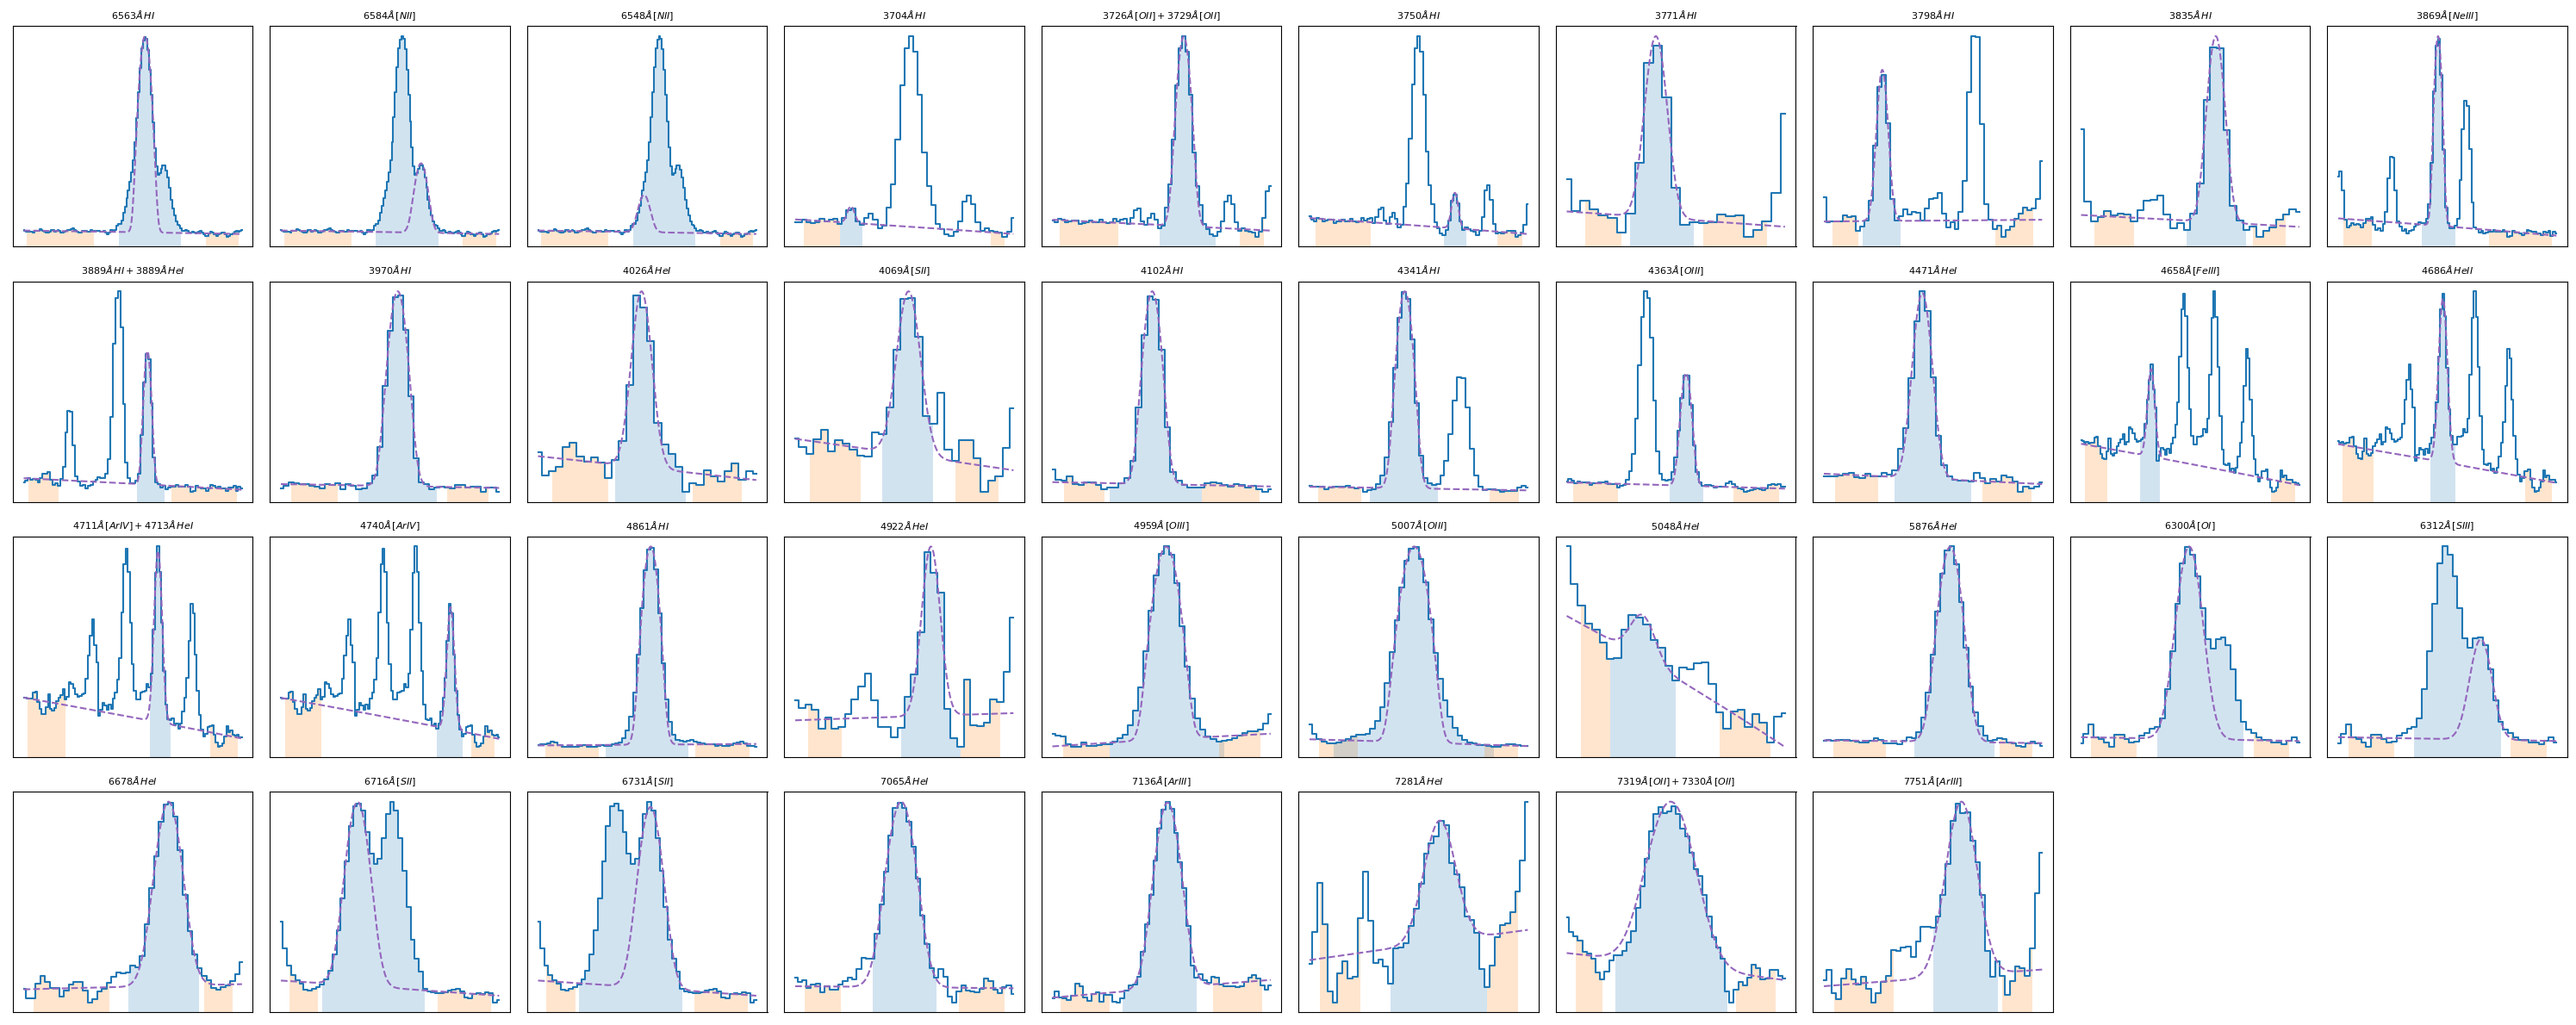

In [52]:
gp_spec.plot_line_grid(gp_spec.linesDF)

## Storing the measurements

Finally, the results can be saved as a text table, pdf or fits file using the save_lines_log command:

In [53]:
lime.save_line_log(gp_spec.linesDF, 'gp121903_linelog', 'txt')
lime.save_line_log(gp_spec.linesDF, 'gp121903_linelog', 'pdf')
lime.save_line_log(gp_spec.linesDF, 'gp121903_linelog', 'fits')
lime.save_line_log(gp_spec.linesDF, 'gp121903_linelog', 'xlsx')

Some output formats (pdf, xlsx) might require you to some third party libraries or packages